In [166]:
import os
from pathlib import Path

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nb

## Behavioural data - CDS subscale  x metacognition in patients

In [91]:
mri_sample = pd.read_csv("mri_sample_stats.tsv", sep="\t", index_col=0)
regressors = mri_sample[["age", "group", "mean_fd", "CDS_State"]]
for c in ["control", "patient"]:
    regressors[c] = 0
    regressors[c][regressors.group == c] = 1
regressors.group = 1
z_convert = ["age", "mean_fd", "CDS_State"]
regressors[z_convert] -= regressors[z_convert].mean()
regressors[z_convert] /= regressors[z_convert] .std(ddof=0)
regressors.to_csv("mri_regressors.tsv", sep="\t")

/home/hw1012/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hw1012/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [105]:
stats = pd.read_csv("full_sample_stats.tsv", sep="\t", index_col=0)
mri_sample = pd.read_csv("mri_sample_stats.tsv", sep="\t", index_col=0)

# rename some variables for viz
select_name = ["Awareness:\ninteroceptive > extroceptive", 
               "Alienation from surroundings", 
               "Anomalous subjective recall", 
               "Emotion numbing", 
               "Anomalous body experience"]
select_var = ["HeartAwaremNoteAware", "AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot"]

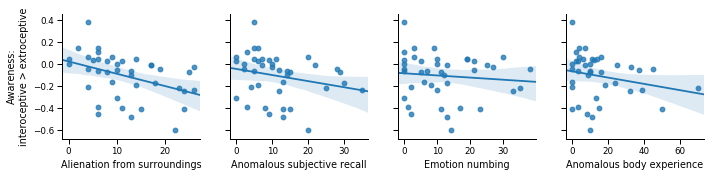

In [113]:
sns.set_context("paper")
data = stats[select_var]
data.columns = select_name
sns.pairplot(data, 
             x_vars=select_name[1:], 
             y_vars=select_name[0],
             kind="reg")

## Introception > extroception

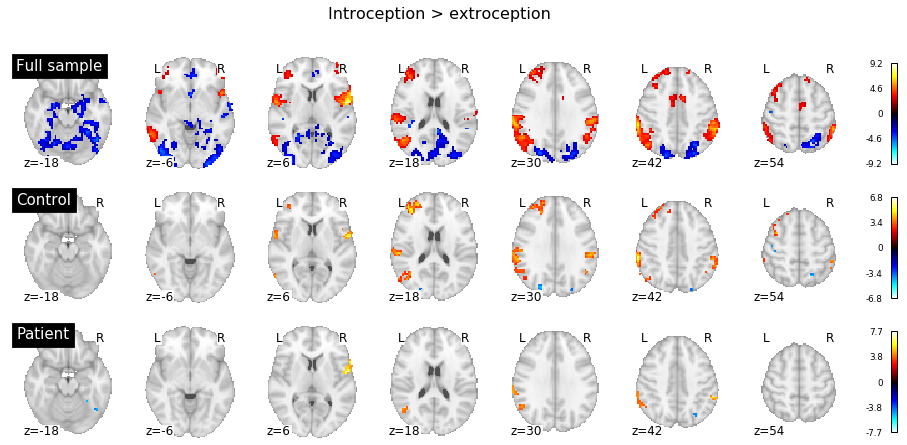

In [165]:
p = 0.05
nii_dir = Path("./glm_niftis")

fig, axs = plt.subplots(3, 1, figsize=(16, 7))
fig.suptitle("Introception > extroception", fontsize=16)
for i, (name, g) in enumerate(zip(["Full sample", "Control", "Patient"], ["fullsample", "control", "patient"])):
    pos = list(nii_dir.glob("FSL_PPI/hammersmith_insula_anterior_inferior_cortex_L/contrast_[^h]*_wrt_[a-z]*"))[0]
    neg = list(nii_dir.glob("FSL_PPI/hammersmith_insula_anterior_inferior_cortex_L/contrast_[^n]*_wrt_[a-z]*"))[0]
    contrast_name = pos.name
    pos_tstat = f"{str(pos)}/{g}_tstat.nii.gz"
    pos_tfce = f"{str(pos)}/{g}_tfce_corrp_tstat.nii.gz"
    neg_tfce = f"{str(neg)}/{g}_tfce_corrp_tstat.nii.gz"
    mask = np.zeros(nb.load(pos_tfce).shape)
    for path in [pos_tfce, neg_tfce]:
        tfce_nii = nb.load(path)
        mask += (tfce_nii.get_fdata() > (1 - p)).astype(int)
    mask = (mask > 0).astype(int)
    if mask.sum() > 0: # only plot real values
        data = nb.load(pos_tstat).get_fdata() * mask
        sig_tstat = nb.Nifti1Image(data, 
                                   header=tfce_nii.header, 
                                   affine=tfce_nii.affine)
        plotting.plot_stat_map(sig_tstat, display_mode="z", cut_coords=range(-18, 59, 12),
                               draw_cross=False, title=name, axes=axs[i])

## PPI

probmap-gm-r86-insula_anterior_short_gyrus_L.nii.gz
probmap-gm-r87-insula_anterior_short_gyrus_R.nii.gz
probmap-gm-r88-insula_middle_short_gyrus_L.nii.gz
probmap-gm-r89-insula_middle_short_gyrus_R.nii.gz
probmap-gm-r92-insula_anterior_inferior_cortex_L.nii.gz
probmap-gm-r93-insula_anterior_inferior_cortex_R.nii.gz


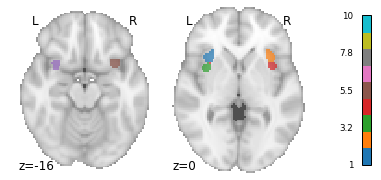

In [163]:
seed_dir = Path("../references/insular_masks")
for i, p in enumerate(sorted(list(seed_dir.glob("probmap-gm*")))):
    cur_path = str(p)
    if i == 0:
        roi = np.zeros(nb.load(p).get_fdata().shape)
    cur_roi = nb.load(p).get_fdata() * (i + 1)
    roi += cur_roi
    print(p.name)
roi_nii = nb.Nifti1Image(roi,
                         header=nb.load(p).header, 
                         affine=nb.load(p).affine)
plotting.plot_roi(roi_nii, display_mode="z", cut_coords=[-16, 0], 
                  cmap="tab10", colorbar=True, vmax=10)

## cope value x continutous HRV